I want to learn how to know how big (depth, max_seq_len) a model I can create and have it still fit on my GPU.

In [690]:
import torch
import gc

### Toy example

Let me start by seeing if I can understand it for a simple model.

In [2]:
torch.cuda.is_available()

True

In [3]:
free, total = torch.cuda.mem_get_info()
free, total

(8249999360, 8354660352)

In [4]:
print(f"Free memory: {free / 1024**3:.2f} GB")
print(f"Total memory: {total / 1024**3:.2f} GB")

Free memory: 7.68 GB
Total memory: 7.78 GB


In [5]:
allocated = torch.cuda.memory_allocated()
allocated

0

In [6]:
free_before = free

In [7]:
model = torch.nn.Linear(in_features=10, out_features=10, bias=False, device="cuda", dtype=torch.float32)

In [8]:
# this should have 100 params, each 32 bits = 4 bytes, so guessing consumes this many bytes:
100 * 4

400

In [9]:
free, total = torch.cuda.mem_get_info()
free_before - free

4194304

In [10]:
torch.cuda.memory_allocated()

512

Is the 512 because it allocates in certain minimum units? Let's try a few things.

In [11]:
del model
gc.collect()
torch.cuda.empty_cache()
torch.cuda.memory_allocated()

0

In [12]:
# first confirm repeatable
model = torch.nn.Linear(in_features=10, out_features=10, bias=False, device="cuda", dtype=torch.float32)
torch.cuda.memory_allocated()

512

In [13]:
del model
gc.collect()
torch.cuda.empty_cache()
torch.cuda.memory_allocated()

0

In [14]:
# 11 x 11 x 4 = 484, so guessing we'll still see 512
model = torch.nn.Linear(in_features=11, out_features=11, bias=False, device="cuda", dtype=torch.float32)

In [15]:
torch.cuda.memory_allocated()

512

In [20]:
del model
gc.collect()
torch.cuda.empty_cache()
torch.cuda.memory_allocated()

0

In [21]:
# 12 x 12 x 4 = 576, so guessing we'll still see 1024
model = torch.nn.Linear(in_features=12, out_features=12, bias=False, device="cuda", dtype=torch.float32)

In [22]:
torch.cuda.memory_allocated()

1024

What about the gradient? Does that space get allocated only as needed? Let's try.

In [25]:
x = torch.randn(12, device="cuda")

In [26]:
torch.cuda.memory_allocated()
# 1024 + 512 = 1636

1536

In [27]:
loss = model(x).sum()

In [28]:
torch.cuda.memory_allocated()

8521728

What's that all about? Is that memory that gets allocated to do the forward pass? Maybe we should start even simpler and see what happens if we allocte two tensors and multiply them. But first see what happens when we call backward().

In [31]:
loss.backward()

In [32]:
torch.cuda.memory_allocated()

17042432

In [37]:
model.weight.grad

tensor([[ 0.6030, -1.4976,  0.3691, -1.1289,  0.7871, -1.1535,  0.2922,  0.8758,
         -0.8272, -0.8537,  0.0650,  0.6997],
        [ 0.6030, -1.4976,  0.3691, -1.1289,  0.7871, -1.1535,  0.2922,  0.8758,
         -0.8272, -0.8537,  0.0650,  0.6997],
        [ 0.6030, -1.4976,  0.3691, -1.1289,  0.7871, -1.1535,  0.2922,  0.8758,
         -0.8272, -0.8537,  0.0650,  0.6997],
        [ 0.6030, -1.4976,  0.3691, -1.1289,  0.7871, -1.1535,  0.2922,  0.8758,
         -0.8272, -0.8537,  0.0650,  0.6997],
        [ 0.6030, -1.4976,  0.3691, -1.1289,  0.7871, -1.1535,  0.2922,  0.8758,
         -0.8272, -0.8537,  0.0650,  0.6997],
        [ 0.6030, -1.4976,  0.3691, -1.1289,  0.7871, -1.1535,  0.2922,  0.8758,
         -0.8272, -0.8537,  0.0650,  0.6997],
        [ 0.6030, -1.4976,  0.3691, -1.1289,  0.7871, -1.1535,  0.2922,  0.8758,
         -0.8272, -0.8537,  0.0650,  0.6997],
        [ 0.6030, -1.4976,  0.3691, -1.1289,  0.7871, -1.1535,  0.2922,  0.8758,
         -0.8272, -0.8537,  0.

In [47]:
model.weight.untyped_storage().nbytes()

576

In [48]:
model.weight.grad.untyped_storage().nbytes()

576

In [49]:
x.untyped_storage().nbytes()

48

In [50]:
loss.untyped_storage().nbytes()

4

Maybe it's not such a good idea to try to line things up at this level with `torch.cuda.memory_allocated()` because torch (or lower-level stuff?) could be allocating caches, etc. Let's see how things work with bigger numbers. But first, let's see what happens with allocating and multiplying raw tensors. My hope is there the numbers will match up.

Also, could jupyter be holding onto things?

In [1]:
## restart kernel ##
import torch
import gc

In [2]:
torch.cuda.memory_allocated()

0

In [3]:
m = torch.randn(12, 12, device="cuda", dtype=torch.float32)

In [4]:
torch.cuda.memory_allocated()

1024

In [5]:
m.untyped_storage().nbytes()

576

In [6]:
x = torch.randn(12, device="cuda", dtype=torch.float32)

In [7]:
torch.cuda.memory_allocated() # expecting 1024 + 512 = 1536

1536

In [8]:
y = m @ x

In [9]:
torch.cuda.memory_allocated() # expecting 1024 + 512 + 512 = 2048

8521728

No. Maybe as soon as you do matrix math it allocates memory for something?

In [11]:
torch.cuda.empty_cache()

In [12]:
torch.cuda.memory_allocated()

8521728

Does torch.no_grad() matter?

In [1]:
## restart kernel ##
import torch
import gc
torch.cuda.memory_allocated()

0

In [2]:
m = torch.randn(12, 12, device="cuda", dtype=torch.float32)
x = torch.randn(12, device="cuda", dtype=torch.float32)

In [3]:
torch.cuda.memory_allocated()

1536

In [4]:
with torch.no_grad():
    y = m @ x

In [5]:
torch.cuda.memory_allocated()

8521728

How about preallocating space for the result?

In [1]:
## restart kernel ##
import torch
import gc
torch.cuda.memory_allocated()

0

In [2]:
m = torch.randn(12, 12, device="cuda", dtype=torch.float32)
x = torch.randn(12, device="cuda", dtype=torch.float32)
y = torch.empty_like(x)

In [3]:
torch.cuda.memory_allocated()

2048

In [4]:
foo = torch.matmul(m, x, out=y)
del foo
gc.collect()
torch.cuda.empty_cache()

In [5]:
torch.cuda.memory_allocated()

8521728

Not sure, let's try with much bigger numbers and see. Maybe the unaccounted for stuff is fixed stuff that will become a rounding error at bigger sizes.

In [1]:
## restart kernel ##
import torch
import gc
torch.cuda.memory_allocated()

0

In [2]:
m = torch.randn(1000, 1000, device="cuda", dtype=torch.float32) # 4,000,000 bytes
x = torch.randn(1000, device="cuda", dtype=torch.float32) # 4000 bytes

In [3]:
torch.cuda.memory_allocated()

4004352

In [4]:
m.untyped_storage().nbytes(), x.untyped_storage().nbytes()

(4000000, 4000)

In [5]:
y = m @ x

In [7]:
y.untyped_storage().nbytes()

4000

In [6]:
torch.cuda.memory_allocated()

12528128

No. It jumps from ~4M to ~12M. Why?

In [9]:
torch.cuda.empty_cache()
torch.cuda.memory_allocated()

12528128

What if the tensors large enough that they and the result take up all the space?

In [1]:
## restart kernel ##
import torch
import gc
torch.cuda.memory_allocated()

0

In [2]:
free, total = torch.cuda.mem_get_info()
f"{free:,}"

'8,249,999,360'

In [3]:
import math
math.sqrt(free / 4)

45414.753549920315

In [4]:
m = torch.randn(40_000, 40_000, device="cuda", dtype=torch.float32)
x = torch.randn(40_000, device="cuda", dtype=torch.float32)

In [5]:
m.untyped_storage().nbytes() + x.untyped_storage().nbytes()

6400160000

In [6]:
f"{torch.cuda.memory_allocated():,}"

'6,400,668,160'

In [7]:
y = m @ x

In [8]:
y.untyped_storage().nbytes()

160000

In [9]:
f"{torch.cuda.memory_allocated():,}"

'6,409,348,096'

In [10]:
free, total = torch.cuda.mem_get_info()
f"{free:,}"

'1,813,839,872'

well, that worked, and the "extra" increase after the multiplication was "only" ~9M:

In [11]:
torch.cuda.memory_allocated() - (m.untyped_storage().nbytes() + x.untyped_storage().nbytes() + y.untyped_storage().nbytes())

9028096

so maybe it's not worth worrying about exactly how this works, but what happens if we go back to the simple linear model with the same large number of params. Will the forward pass work but it will fail with an out of memory problem when call backward() because it doesn't have room to store the gradient?

In [1]:
## restart kernel ##
import torch
import gc
torch.cuda.memory_allocated()

0

In [2]:
model = torch.nn.Linear(in_features=40_000, out_features=40_000, bias=False, device="cuda", dtype=torch.float32)

In [3]:
f"{torch.cuda.memory_allocated():,}"

'6,400,507,904'

In [4]:
x = torch.randn(40_000, device="cuda", dtype=torch.float32)

In [5]:
f"{torch.cuda.memory_allocated():,}"

'6,400,668,160'

In [6]:
loss = model(x).sum()

In [7]:
f"{torch.cuda.memory_allocated():,}"

'6,409,188,352'

In [8]:
loss.backward()

OutOfMemoryError: CUDA out of memory. Tried to allocate 5.96 GiB. GPU 0 has a total capacity of 7.78 GiB of which 1.68 GiB is free. Including non-PyTorch memory, this process has 6.10 GiB memory in use. Of the allocated memory 5.97 GiB is allocated by PyTorch, and 13.72 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

### bfloat16

Another thing I want to understand before digging into the real model is bfloat16.

I ended up spending way more time than the few minutes I thought it would take to see how torch.float32 works and moved the explortation to `understand-torch-float32.ipynb`. If nothing else I'll be more cautious about numerical precision and understand that float are not magical, for example, why the way the encoding works causes the following:

In [715]:
torch.tensor(12345678912, dtype=torch.float32).item()

12345678848.0

In [707]:
torch.tensor(1.2345e-20, dtype=torch.float32).item()

1.2345000173693373e-20

In [711]:
torch.tensor(1.2345678e-5, dtype=torch.float32).item()

1.2345678442216013e-05

In [713]:
torch.tensor(1.2345678e5, dtype=torch.float32).item()

123456.78125

### "Hand" calculate memory for the gpt model

Let's use the sizes from the baby pretrain notebook

In [952]:
import matplotlib.pyplot as plt

In [953]:
# example config

depth = 4
max_seq_len = 128

num_layers = depth
model_dim = depth * 64 # 256
num_heads = max(1, (model_dim + 127) // 128)
num_kv_heads = num_heads # 2

vocab_size = 65537

device_batch_size = 1
total_batch_size = device_batch_size * max_seq_len

In [954]:
n_wte_params = vocab_size * model_dim
n_attn_params = num_layers * 4 * model_dim * model_dim # (c_q, c_k, c_v, c_proj)
n_mlp_params = num_layers * 2 * model_dim * 4 * model_dim # (c_fc, c_proj)
n_lm_head_params = model_dim * vocab_size
n_precomputed_cos_sin_params = 10 * max_seq_len * (model_dim // num_heads)
n_total_params = n_wte_param + n_attn_params + n_mlp_params + n_lm_head_params + n_precomputed_cos_sin_params
n_wte_params, n_attn_params, n_mlp_params, n_lm_head_params, n_precomputed_cos_sin_params

(16777472, 1048576, 2097152, 16777472, 163840)

In [955]:
print(f"{n_total_params:,d}")

36,864,512


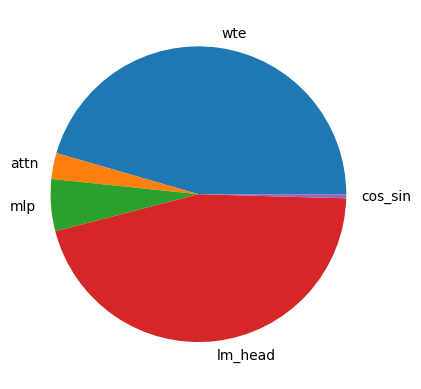

In [956]:
plt.pie(
    [n_wte_params, n_attn_params, n_mlp_params, n_lm_head_params, n_precomputed_cos_sin_params],
    labels=['wte', 'attn', 'mlp', 'lm_head', 'cos_sin']);

In [957]:
# GPU
wte_bytes = n_wte_params * 2 # on GPU, wte is set to bfloat16
attn_bytes = n_attn_params * 4
mlp_bytes = n_mlp_params * 4
lm_head_bytes = n_lm_head_params * 4
precomputed_cos_sin_bytes = n_precomputed_cos_sin_params * 2 # uses bfloat16 on CPU and GPU
wte_bytes, attn_bytes, mlp_bytes, lm_head_bytes, precomputed_cos_sin_bytes

(33554944, 4194304, 8388608, 67109888, 327680)

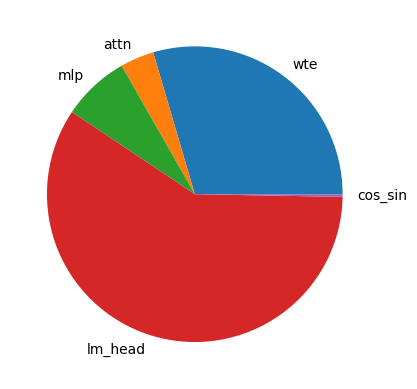

In [958]:
plt.pie(
    [wte_bytes, attn_bytes, mlp_bytes, lm_head_bytes, precomputed_cos_sin_bytes],
    labels=['wte', 'attn', 'mlp', 'lm_head', 'cos_sin']);

In [959]:
# adding in gradients and tensors the optimizers must use
wte_bytes += wte_bytes # gradient (not sure what muon is yet and if it needs to maintain other large tensors)
attn_bytes += attn_bytes * 3 # gradient, m and v in AdamW optimizer (moving averages)
mlp_bytes += mlp_bytes * 3 # gradient, m and v in AdamW optimizer 
lm_head_bytes += lm_head_bytes * 3 # gradient, m and v in AdamW optimizer

In [960]:
# Really rough...sure none of this is meaningful...more just to think about...also not sure when
# memory can be freed
other_bytes_needed = 0
other_bytes_needed += total_batch_size * 4 # x, the input batch (int32)
other_bytes_needed += total_batch_size * 8 # y, the targets (int64)
other_bytes_needed += total_batch_size * model_dim * 4 # the output of hidden layers
other_bytes_needed += total_batch_size * 4 # overall output (the logits)
other_bytes_needed += total_batch_size * model_dim * 4 # one more interim tensor (?)
other_bytes_needed

264192

In [961]:
bytes_needed = wte_bytes + attn_bytes + mlp_bytes + lm_head_bytes + precomputed_cos_sin_bytes + other_bytes_needed

In [962]:
# So for this configuration on GPU estimating need about this many bytes
print(f"{bytes_needed:,d} bytes = {bytes_needed / 1024 ** 3:2.2f} GiB")

386,472,960 bytes = 0.36 GiB


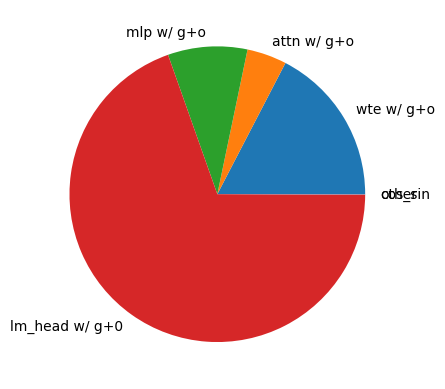

In [964]:
# pie chart of approx bytes needed including for gradients
# (of course I could be missing other big chunks that end up being needed)
plt.pie(
    [wte_bytes * 2, attn_bytes * 2, mlp_bytes * 2, lm_head_bytes * 2, precomputed_cos_sin_bytes, other_bytes_needed],
    labels=['wte w/ g+o', 'attn w/ g+o', 'mlp w/ g+o', 'lm_head w/ g+0', 'cos_sin', 'other']);

Check with actual model:

In [965]:
import sys
sys.path.append('../my_nanochat')
from my_nanochat.my_gpt import GPTConfig, GPT
from my_nanochat.my_common import autodetect_device_type

In [966]:
device = autodetect_device_type()

Autodetected device type: mps


In [967]:
model_config_kwargs = dict(sequence_len=max_seq_len, vocab_size=vocab_size, n_layer=num_layers, n_head=num_heads, n_kv_head=num_kv_heads, n_embd=model_dim)
with torch.device("meta"):
    model_config = GPTConfig(**model_config_kwargs)
    model = GPT(model_config)
model.to_empty(device=device)
model.init_weights()

In [968]:
total_params = 0
total_bytes = 0
for param in model.parameters():
    total_params += param.numel()
    total_bytes += param.untyped_storage().nbytes()
    print(f"{param.shape} has {param.numel():,d} elements using {param.untyped_storage().nbytes():,d} bytes")

torch.Size([65537, 256]) has 16,777,472 elements using 67,109,888 bytes
torch.Size([256, 256]) has 65,536 elements using 262,144 bytes
torch.Size([256, 256]) has 65,536 elements using 262,144 bytes
torch.Size([256, 256]) has 65,536 elements using 262,144 bytes
torch.Size([256, 256]) has 65,536 elements using 262,144 bytes
torch.Size([1024, 256]) has 262,144 elements using 1,048,576 bytes
torch.Size([256, 1024]) has 262,144 elements using 1,048,576 bytes
torch.Size([256, 256]) has 65,536 elements using 262,144 bytes
torch.Size([256, 256]) has 65,536 elements using 262,144 bytes
torch.Size([256, 256]) has 65,536 elements using 262,144 bytes
torch.Size([256, 256]) has 65,536 elements using 262,144 bytes
torch.Size([1024, 256]) has 262,144 elements using 1,048,576 bytes
torch.Size([256, 1024]) has 262,144 elements using 1,048,576 bytes
torch.Size([256, 256]) has 65,536 elements using 262,144 bytes
torch.Size([256, 256]) has 65,536 elements using 262,144 bytes
torch.Size([256, 256]) has 65,

In [974]:
total_params, total_bytes

(73729024, 294260736)

In [975]:
for name, buf in model.named_buffers():
    total_params += buf.numel()
    total_bytes += buf.untyped_storage().nbytes()
    print(name, buf.shape, buf.numel(), buf.untyped_storage().nbytes())

cos torch.Size([1, 1280, 1, 64]) 81920 163840
sin torch.Size([1, 1280, 1, 64]) 81920 163840


In [976]:
print(f"total params: {total_params:,d}")
print(f"total bytes: {total_bytes:,d} bytes = {total_bytes / 1024 ** 3:2.2f} GiB")

total params: 73,892,864
total bytes: 294,588,416 bytes = 0.27 GiB


^ But that leaves out a huge amount (gradients, optimizers, other tensors)

### Now with bigger dimensions

Repeat the cells above but with more realistic dimensions. Want to see how the pie chart looks.

In [999]:
# config from his d20 in speedrun.sh / base_train.py

depth = 20
max_seq_len = 2048

num_layers = depth
model_dim = depth * 64
num_heads = max(1, (model_dim + 127) // 128)
num_kv_heads = num_heads

vocab_size = 65537

device_batch_size = 32
total_batch_size = device_batch_size * max_seq_len

In [1000]:
n_wte_params = vocab_size * model_dim
n_attn_params = num_layers * 4 * model_dim * model_dim # (c_q, c_k, c_v, c_proj)
n_mlp_params = num_layers * 2 * model_dim * 4 * model_dim # (c_fc, c_proj)
n_lm_head_params = model_dim * vocab_size
n_precomputed_cos_sin_params = 10 * max_seq_len * (model_dim // num_heads)
n_total_params = n_wte_param + n_attn_params + n_mlp_params + n_lm_head_params + n_precomputed_cos_sin_params
n_wte_params, n_attn_params, n_mlp_params, n_lm_head_params, n_precomputed_cos_sin_params

(83887360, 131072000, 262144000, 83887360, 2621440)

In [1001]:
print(f"{n_total_params:,d}")

496,502,272


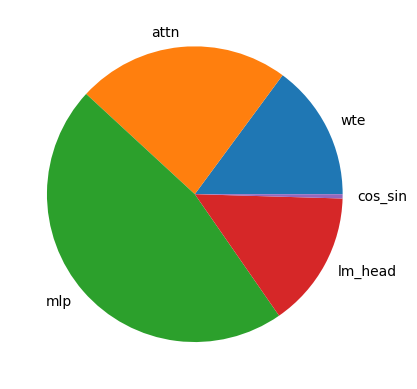

In [1002]:
plt.pie(
    [n_wte_params, n_attn_params, n_mlp_params, n_lm_head_params, n_precomputed_cos_sin_params],
    labels=['wte', 'attn', 'mlp', 'lm_head', 'cos_sin']);

In [1003]:
# GPU
wte_bytes = n_wte_params * 2 # on GPU, wte is set to bfloat16
attn_bytes = n_attn_params * 4
mlp_bytes = n_mlp_params * 4
lm_head_bytes = n_lm_head_params * 4
precomputed_cos_sin_bytes = n_precomputed_cos_sin_params * 2 # uses bfloat16 on CPU and GPU
wte_bytes, attn_bytes, mlp_bytes, lm_head_bytes, precomputed_cos_sin_bytes

(167774720, 524288000, 1048576000, 335549440, 5242880)

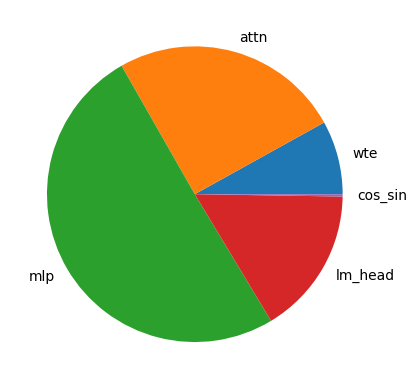

In [1004]:
plt.pie(
    [wte_bytes, attn_bytes, mlp_bytes, lm_head_bytes, precomputed_cos_sin_bytes],
    labels=['wte', 'attn', 'mlp', 'lm_head', 'cos_sin']);

In [1005]:
# adding in gradients and tensors the optimizers must use
wte_bytes += wte_bytes # gradient (not sure what muon is yet and if it needs to maintain other large tensors)
attn_bytes += attn_bytes * 3 # gradient, m and v in AdamW optimizer (moving averages)
mlp_bytes += mlp_bytes * 3 # gradient, m and v in AdamW optimizer 
lm_head_bytes += lm_head_bytes * 3 # gradient, m and v in AdamW optimizer

In [1006]:
# Really rough...sure none of this is meaningful...more just to think about...also not sure when
# memory can be freed
other_bytes_needed = 0
other_bytes_needed += total_batch_size * 4 # x, the input batch (int32)
other_bytes_needed += total_batch_size * 8 # y, the targets (int64)
other_bytes_needed += total_batch_size * model_dim * 4 # the output of hidden layers
other_bytes_needed += total_batch_size * 4 # overall output (the logits)
other_bytes_needed += total_batch_size * model_dim * 4 # one more interim tensor (?)
other_bytes_needed

672137216

In [1007]:
bytes_needed = wte_bytes + attn_bytes + mlp_bytes + lm_head_bytes + precomputed_cos_sin_bytes + other_bytes_needed

In [1008]:
# So for this configuration on GPU estimating need about this many bytes
print(f"{bytes_needed:,d} bytes = {bytes_needed / 1024 ** 3:2.2f} GiB")

8,646,583,296 bytes = 8.05 GiB


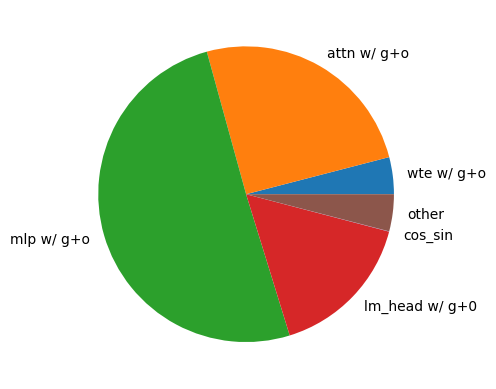

In [1009]:
# pie chart of approx bytes needed including for gradients
# (of course I could be missing other big chunks that end up being needed)
plt.pie(
    [wte_bytes * 2, attn_bytes * 2, mlp_bytes * 2, lm_head_bytes * 2, precomputed_cos_sin_bytes, other_bytes_needed],
    labels=['wte w/ g+o', 'attn w/ g+o', 'mlp w/ g+o', 'lm_head w/ g+0', 'cos_sin', 'other']);

^ So even if I'm in the right ballpark for "other" it's not insigificant. Changing batch size will adjust other while leaving everything else, so maybe the idea is to make batch size as large as possible before running out of memory to maximize GPU during training.

Check with actual model:

In [1010]:
import sys
sys.path.append('../my_nanochat')
from my_nanochat.my_gpt import GPTConfig, GPT
from my_nanochat.my_common import autodetect_device_type

In [1011]:
device = autodetect_device_type()

Autodetected device type: mps


In [1012]:
model_config_kwargs = dict(sequence_len=max_seq_len, vocab_size=vocab_size, n_layer=num_layers, n_head=num_heads, n_kv_head=num_kv_heads, n_embd=model_dim)
with torch.device("meta"):
    model_config = GPTConfig(**model_config_kwargs)
    model = GPT(model_config)
model.to_empty(device=device)
model.init_weights()

In [1013]:
total_params = 0
total_bytes = 0
for param in model.parameters():
    total_params += param.numel()
    total_bytes += param.untyped_storage().nbytes()
    print(f"{param.shape} has {param.numel():,d} elements using {param.untyped_storage().nbytes():,d} bytes")

torch.Size([65537, 1280]) has 83,887,360 elements using 335,549,440 bytes
torch.Size([1280, 1280]) has 1,638,400 elements using 6,553,600 bytes
torch.Size([1280, 1280]) has 1,638,400 elements using 6,553,600 bytes
torch.Size([1280, 1280]) has 1,638,400 elements using 6,553,600 bytes
torch.Size([1280, 1280]) has 1,638,400 elements using 6,553,600 bytes
torch.Size([5120, 1280]) has 6,553,600 elements using 26,214,400 bytes
torch.Size([1280, 5120]) has 6,553,600 elements using 26,214,400 bytes
torch.Size([1280, 1280]) has 1,638,400 elements using 6,553,600 bytes
torch.Size([1280, 1280]) has 1,638,400 elements using 6,553,600 bytes
torch.Size([1280, 1280]) has 1,638,400 elements using 6,553,600 bytes
torch.Size([1280, 1280]) has 1,638,400 elements using 6,553,600 bytes
torch.Size([5120, 1280]) has 6,553,600 elements using 26,214,400 bytes
torch.Size([1280, 5120]) has 6,553,600 elements using 26,214,400 bytes
torch.Size([1280, 1280]) has 1,638,400 elements using 6,553,600 bytes
torch.Size([

In [1014]:
total_params, total_bytes

(560990720, 2243962880)

In [1015]:
for name, buf in model.named_buffers():
    total_params += buf.numel()
    total_bytes += buf.untyped_storage().nbytes()
    print(name, buf.shape, buf.numel(), buf.untyped_storage().nbytes())

cos torch.Size([1, 20480, 1, 64]) 1310720 2621440
sin torch.Size([1, 20480, 1, 64]) 1310720 2621440


In [1016]:
print(f"total params: {total_params:,d}")
print(f"total bytes: {total_bytes:,d} bytes = {total_bytes / 1024 ** 3:2.2f} GiB")

total params: 563,612,160
total bytes: 2,249,205,760 bytes = 2.09 GiB


^ But that leaves out a huge amount (gradients, optimizers, other tensors)

### Put estimate code in a function

I want a function that will spit out my estimate so that I can try various sizes and "search" for where I run out of memory on the GPU. Also have function return model config kwargs.

In [1027]:
def estimate_bytes_needed(depth=20, max_seq_len=2048, device_batch_size=32):
    num_layers = depth
    model_dim = depth * 64
    num_heads = max(1, (model_dim + 127) // 128)
    num_kv_heads = num_heads
    vocab_size = 65537
    total_batch_size = device_batch_size * max_seq_len

    n_wte_params = vocab_size * model_dim
    n_attn_params = num_layers * 4 * model_dim * model_dim # (c_q, c_k, c_v, c_proj)
    n_mlp_params = num_layers * 2 * model_dim * 4 * model_dim # (c_fc, c_proj)
    n_lm_head_params = model_dim * vocab_size
    n_precomputed_cos_sin_params = 10 * max_seq_len * (model_dim // num_heads)

    wte_bytes = n_wte_params * 2 # on GPU, wte is set to bfloat16
    attn_bytes = n_attn_params * 4
    mlp_bytes = n_mlp_params * 4
    lm_head_bytes = n_lm_head_params * 4
    precomputed_cos_sin_bytes = n_precomputed_cos_sin_params * 2 # uses bfloat16 on CPU and GPU

    # adding in gradients and tensors the optimizers must use
    wte_bytes += wte_bytes # gradient (not sure what muon is yet and if it needs to maintain other large tensors)
    attn_bytes += attn_bytes * 3 # gradient, m and v in AdamW optimizer (moving averages)
    mlp_bytes += mlp_bytes * 3 # gradient, m and v in AdamW optimizer 
    lm_head_bytes += lm_head_bytes * 3 # gradient, m and v in AdamW optimizer

    # Really rough...sure none of this is meaningful...more just to think about...also not sure when
    # memory can be freed
    other_bytes_needed = 0
    other_bytes_needed += total_batch_size * 4 # x, the input batch (int32)
    other_bytes_needed += total_batch_size * 8 # y, the targets (int64)
    other_bytes_needed += total_batch_size * model_dim * 4 # the output of hidden layers
    other_bytes_needed += total_batch_size * 4 # overall output (the logits)
    other_bytes_needed += total_batch_size * model_dim * 4 # one more interim tensor (?)

    bytes_needed = wte_bytes + attn_bytes + mlp_bytes + lm_head_bytes + precomputed_cos_sin_bytes + other_bytes_needed
    print(f"{bytes_needed:,d} bytes = {bytes_needed / 1024 ** 3:2.2f} GiB")

    model_config_kwargs = dict(
        sequence_len=max_seq_len,
        vocab_size=vocab_size,
        n_layer=num_layers,
        n_head=num_heads,
        n_kv_head=num_kv_heads,
        n_embd=model_dim
    )
    
    return bytes_needed, model_config_kwargs, vocab_size

In [1028]:
bytes_needed, model_config_kwargs, vocab_size = estimate_bytes_needed(depth=20, max_seq_len=2048, device_batch_size=32)
model_config_kwargs

8,646,583,296 bytes = 8.05 GiB


{'sequence_len': 2048,
 'vocab_size': 65537,
 'n_layer': 20,
 'n_head': 10,
 'n_kv_head': 10,
 'n_embd': 1280}

### Figure out when we run out of memory

In [1036]:
def create_model_and_do_one_training_step(depth, max_seq_len, device_batch_size):
    device = autodetect_device_type()
    _, model_config_kwargs, vocab_size = estimate_bytes_needed(depth, max_seq_len, device_batch_size)
    with torch.device("meta"):
        model_config = GPTConfig(**model_config_kwargs)
        model = GPT(model_config)
    model.to_empty(device=device)
    model.init_weights()
    optimizers = model.setup_optimizers()
    x = torch.randint(0, vocab_size, (device_batch_size, max_seq_len), dtype=torch.int32, device=device)
    y = torch.randint(0, vocab_size, (device_batch_size, max_seq_len), dtype=torch.int32, device=device)
    loss = model(x,y)
    loss.backward()
    for opt in optimizers:
        opt.step()
    return loss

In [1037]:
create_model_and_do_one_training_step(depth=4, max_seq_len=128, device_batch_size=1)

Autodetected device type: mps
386,472,960 bytes = 0.36 GiB
Scaling the LR for the AdamW parameters proportional to 1/sqrt(256/768) = 1.7320508075688774


tensor(11.0904, device='mps:0', grad_fn=<NllLossBackward0>)

In [1038]:
create_model_and_do_one_training_step(depth=4, max_seq_len=256, device_batch_size=1)

Autodetected device type: mps
387,064,832 bytes = 0.36 GiB
Scaling the LR for the AdamW parameters proportional to 1/sqrt(256/768) = 1.7320508075688774


tensor(11.0904, device='mps:0', grad_fn=<NllLossBackward0>)

In [1042]:
create_model_and_do_one_training_step(depth=8, max_seq_len=2048, device_batch_size=1)

Autodetected device type: mps
1,087,416,320 bytes = 1.01 GiB
Scaling the LR for the AdamW parameters proportional to 1/sqrt(512/768) = 1.2247448713915892


RuntimeError: MPS backend out of memory (MPS allocated: 16.94 GiB, other allocations: 902.36 MiB, max allowed: 18.13 GiB). Tried to allocate 512.01 MiB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).